<a href="https://colab.research.google.com/github/mysterytony/cs230_project/blob/main/cs230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#@title setup

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa
    !pip install git+https://github.com/ashweta1/transformer-utils.git


from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from functools import partial
from IPython.display import HTML, IFrame
from jaxtyping import Float
from os import environ
from transformer_lens import ActivationCache, HookedTransformer
from typing import List, Optional, Union
import circuitsvis as cv
import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly
import torch
import tqdm.auto as tqdm
import transformer_lens
import transformer_lens.utils as utils
import itertools
from transformer_utils.logit_lens import plot_logit_lens
import transformers


Running as a Colab notebook


                              DEPRECATION WARNING                            

     Node.js 16.x is no longer actively supported!

  You will not receive security or critical stability updates for this version.

  You should migrate to a supported version of Node.js as soon as possible.
  Use the installation script that corresponds to the version of Node.js you
  wish to install. e.g.
  
   * https://deb.nodesource.com/setup_16.x — Node.js 16 "Gallium" (deprecated)
   * https://deb.nodesource.com/setup_18.x — Node.js 18 "Hydrogen" (Maintenance)
   * https://deb.nodesource.com/setup_19.x — Node.js 19 "Nineteen" (deprecated)
   * https://deb.nodesource.com/setup_20.x — Node.js 20 LTS "Iron" (recommended)
   * https://deb.nodesource.com/setup_21.x — Node.js 21 "Iron" (current)
   


  Please see https://github.com/nodejs/Release for details about which
  version may be appropriate for you.

  The NodeSource Node.js distributions repository contains
  informa

In [12]:
#@title Load Model

torch.set_grad_enabled(False)

DEVICE = utils.get_device()
print(f'{DEVICE=}')

PRETRAINED_MODEL = 'gpt2'  # gpt2-small or gpt2-medium
print(f'{PRETRAINED_MODEL=}')

tokenizer = transformers.AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
hf_model = transformers.AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL)

transformer_lens_model = transformer_lens.HookedTransformer.from_pretrained(
    PRETRAINED_MODEL, center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    hf_model=hf_model,
    tokenizer=tokenizer,
    refactor_factored_attn_matrices=True, device=DEVICE)

print("print huggingface model structure", hf_model)
print("print transformer lens model structure", transformer_lens_model)

DEVICE=device(type='cpu')
PRETRAINED_MODEL='gpt2'
Loaded pretrained model gpt2 into HookedTransformer
print model structure GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


In [13]:
#@title Experiment on tokenization (for math prompts)

prompt = "12+34="

# for i in range(len(prompt)):
# add space in various places in the prompt
for add_space_indices in itertools.product([True, False], repeat=len(prompt)):
  prompt_with_space = prompt
  for i, bool_add_space in zip(reversed(range(len(prompt))), reversed(add_space_indices)):
    if bool_add_space:
      prompt_with_space = prompt_with_space[:i] + " " + prompt_with_space[i:]
  print(f'\n{prompt_with_space=}')
  # utils.test_prompt(prompt=prompt_with_space, answer=' 579', model=model, top_k=1)
  utils.test_prompt(prompt=prompt_with_space, answer='579', model=transformer_lens_model, print_details=False)


prompt_with_space=' 1 2 + 3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 7393)]


prompt_with_space=' 1 2 + 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 8371)]


prompt_with_space=' 1 2 + 34 ='


Ranks of the answer tokens: [(' 5', 11), ('79', 115)]


prompt_with_space=' 1 2 + 34='


Ranks of the answer tokens: [(' 5', 9), ('79', 226)]


prompt_with_space=' 1 2 +3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 5554)]


prompt_with_space=' 1 2 +3 4='


Ranks of the answer tokens: [(' 5', 6), ('79', 7607)]


prompt_with_space=' 1 2 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 73)]


prompt_with_space=' 1 2 +34='


Ranks of the answer tokens: [(' 5', 16), ('79', 150)]


prompt_with_space=' 1 2+ 3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 7581)]


prompt_with_space=' 1 2+ 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 11611)]


prompt_with_space=' 1 2+ 34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 260)]


prompt_with_space=' 1 2+ 34='


Ranks of the answer tokens: [(' 5', 24), ('79', 391)]


prompt_with_space=' 1 2+3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 7843)]


prompt_with_space=' 1 2+3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 12431)]


prompt_with_space=' 1 2+34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 165)]


prompt_with_space=' 1 2+34='


Ranks of the answer tokens: [(' 5', 75), ('79', 284)]


prompt_with_space=' 12 + 3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 313)]


prompt_with_space=' 12 + 3 4='


Ranks of the answer tokens: [(' 5', 5), ('79', 653)]


prompt_with_space=' 12 + 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 63)]


prompt_with_space=' 12 + 34='


Ranks of the answer tokens: [(' 5', 11), ('79', 119)]


prompt_with_space=' 12 +3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 332)]


prompt_with_space=' 12 +3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 569)]


prompt_with_space=' 12 +34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 37)]


prompt_with_space=' 12 +34='


Ranks of the answer tokens: [(' 5', 25), ('79', 69)]


prompt_with_space=' 12+ 3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 960)]


prompt_with_space=' 12+ 3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 1833)]


prompt_with_space=' 12+ 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 131)]


prompt_with_space=' 12+ 34='


Ranks of the answer tokens: [(' 5', 40), ('79', 210)]


prompt_with_space=' 12+3 4 ='


Ranks of the answer tokens: [(' 5', 5), ('79', 872)]


prompt_with_space=' 12+3 4='


Ranks of the answer tokens: [(' 5', 24), ('79', 1404)]


prompt_with_space=' 12+34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 94)]


prompt_with_space=' 12+34='


Ranks of the answer tokens: [(' 5', 68), ('79', 140)]


prompt_with_space='1 2 + 3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 6117)]


prompt_with_space='1 2 + 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 6515)]


prompt_with_space='1 2 + 34 ='


Ranks of the answer tokens: [(' 5', 12), ('79', 102)]


prompt_with_space='1 2 + 34='


Ranks of the answer tokens: [(' 5', 9), ('79', 194)]


prompt_with_space='1 2 +3 4 ='


Ranks of the answer tokens: [(' 5', 2), ('79', 4498)]


prompt_with_space='1 2 +3 4='


Ranks of the answer tokens: [(' 5', 10), ('79', 4870)]


prompt_with_space='1 2 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 72)]


prompt_with_space='1 2 +34='


Ranks of the answer tokens: [(' 5', 21), ('79', 132)]


prompt_with_space='1 2+ 3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 8869)]


prompt_with_space='1 2+ 3 4='


Ranks of the answer tokens: [(' 5', 1), ('79', 12214)]


prompt_with_space='1 2+ 34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 321)]


prompt_with_space='1 2+ 34='


Ranks of the answer tokens: [(' 5', 25), ('79', 456)]


prompt_with_space='1 2+3 4 ='


Ranks of the answer tokens: [(' 5', 2), ('79', 9161)]


prompt_with_space='1 2+3 4='


Ranks of the answer tokens: [(' 5', 20), ('79', 12458)]


prompt_with_space='1 2+34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 185)]


prompt_with_space='1 2+34='


Ranks of the answer tokens: [(' 5', 81), ('79', 298)]


prompt_with_space='12 + 3 4 ='


Ranks of the answer tokens: [(' 5', 7), ('79', 330)]


prompt_with_space='12 + 3 4='


Ranks of the answer tokens: [(' 5', 7), ('79', 613)]


prompt_with_space='12 + 34 ='


Ranks of the answer tokens: [(' 5', 7), ('79', 77)]


prompt_with_space='12 + 34='


Ranks of the answer tokens: [(' 5', 11), ('79', 116)]


prompt_with_space='12 +3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 449)]


prompt_with_space='12 +3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 666)]


prompt_with_space='12 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 46)]


prompt_with_space='12 +34='


Ranks of the answer tokens: [(' 5', 23), ('79', 63)]


prompt_with_space='12+ 3 4 ='


Ranks of the answer tokens: [(' 5', 5), ('79', 978)]


prompt_with_space='12+ 3 4='


Ranks of the answer tokens: [(' 5', 18), ('79', 1642)]


prompt_with_space='12+ 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 145)]


prompt_with_space='12+ 34='


Ranks of the answer tokens: [(' 5', 51), ('79', 196)]


prompt_with_space='12+3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 970)]


prompt_with_space='12+3 4='


Ranks of the answer tokens: [(' 5', 34), ('79', 1235)]


prompt_with_space='12+34 ='


Ranks of the answer tokens: [(' 5', 11), ('79', 94)]


prompt_with_space='12+34='


Ranks of the answer tokens: [(' 5', 127), ('79', 103)]

top results:

```


Tokenized prompt: ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 2        Logit: 11.92 Prob:  1.28% Token: | 5|
Top 0th token. Logit: 12.34 Prob:  1.94% Token: | 1|
Performance on answer token:
Rank: 309      Logit:  6.43 Prob:  0.03% Token: |79|
Top 0th token. Logit: 12.09 Prob:  9.01% Token: |
|
Ranks of the answer tokens: [(' 5', 2), ('79', 309)]

Tokenized prompt: ['<|endoftext|>', ' 12', ' 3', ' +', ' 4', ' 5', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.82 Prob:  2.44% Token: | 5|
Top 0th token. Logit: 12.56 Prob:  5.13% Token: |
|
Performance on answer token:
Rank: 1747     Logit:  4.54 Prob:  0.00% Token: |79|
Top 0th token. Logit: 12.84 Prob:  9.16% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 1747)]

Tokenized prompt: ['<|endoftext|>', '1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.91 Prob:  1.23% Token: | 5|
Top 0th token. Logit: 12.24 Prob:  1.71% Token: | 1|
Performance on answer token:
Rank: 283      Logit:  6.63 Prob:  0.04% Token: |79|
Top 0th token. Logit: 12.05 Prob:  8.38% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 283)]

```



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.



222 + 444 = 0.00

The following table shows the average number of points per game


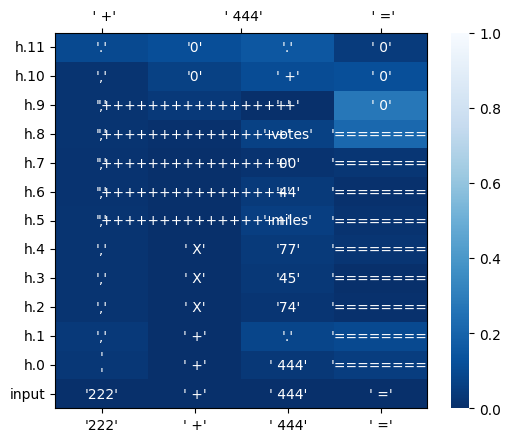

In [26]:
prompt = "222 + 444 ="
tokens = torch.as_tensor(tokenizer.encode(prompt)).view(1, -1).to(DEVICE)
plot_logit_lens(hf_model, tokenizer, tokens, start_ix=0, end_ix=tokens.numel(), probs=True)

out_tokens = hf_model.generate(tokens)
print(tokenizer.decode(out_tokens[0]))

In [11]:
#@title acceptable token on the answers "579" and some wrong answer tokens

# ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
input_token = " 1 2 3 + 45 6="
answer_token = " 579"

output_logit, cache = model.run_with_cache(input_token)
print(f'{output_logit.shape=}')

print('acceptable tokens')
print(f'|5|   token: {model.to_single_token("5")} \t logit: {output_logit[0, -1, model.to_single_token("5")]}')
print(f'|57|  token: {model.to_single_token("57")} \t logit: {output_logit[0, -1, model.to_single_token("57")]}')
print(f'|579| token: {model.to_single_token("579")} \t logit: {output_logit[0, -1, model.to_single_token("579")]}')
print(f'| 5|  token: {model.to_single_token(" 5")} \t logit: {output_logit[0, -1, model.to_single_token(" 5")]}')
print(f'| 57| token: {model.to_single_token(" 57")} \t logit: {output_logit[0, -1, model.to_single_token(" 57")]}')

print('top wrong tokens')
print(f'|1|   token: {model.to_single_token("1")} \t logit: {output_logit[0, -1, model.to_single_token("1")]}')
print(f'| 1|  token: {model.to_single_token(" 1")} \t logit: {output_logit[0, -1, model.to_single_token(" 1")]}')

print(f'|12|  token: {model.to_single_token("12")} \t logit: {output_logit[0, -1, model.to_single_token("12")]}')
print(f'| 7|  token: {model.to_single_token(" 7")} \t logit: {output_logit[0, -1, model.to_single_token(" 7")]}')

right_token_str = ['|5|', '|57|', '|579|', '| 5|', '| 57|']
right_tokens=[20, 3553, 41734, 642, 7632]
wrong_token_str = ['|1|', '| 1|', '|12|', '| 7|']
wrong_tokens=[16, 352, 1065, 767]


accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True, apply_ln=True
)
accumulated_residual_logits = accumulated_residual @ model.unembed.W_U + model.unembed.b_U
fig = go.Figure()
for token_str, t in zip(right_token_str, right_tokens):
  fig.add_trace(go.Scatter(
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
    text=labels,
    name=token_str,
        # line=dict(
        #     color='blue',
        #     # dash ='dot',
        #     # width=3.5,
        # )
  ))
for token_str, t in zip(wrong_token_str, wrong_tokens):
  fig.add_trace(go.Scatter(
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
    text=labels,
    name=token_str,
    # color='royalblue',
    line=dict(
            # color='red',
            dash ='dot',
            # width=3.5,
        )
  ))
fig.show()


output_logit.shape=torch.Size([1, 8, 50257])
acceptable tokens
|5|   token: 20 	 logit: 11.259031295776367
|57|  token: 3553 	 logit: 9.810115814208984
|579| token: 41734 	 logit: 4.527767658233643
| 5|  token: 642 	 logit: 11.922718048095703
| 57| token: 7632 	 logit: 10.250670433044434
top wrong tokens
|1|   token: 16 	 logit: 11.585814476013184
| 1|  token: 352 	 logit: 12.338008880615234
|12|  token: 1065 	 logit: 11.043591499328613
| 7|  token: 767 	 logit: 11.680510520935059


In [ ]:
stack_head_result, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True, apply_ln=True
)
stack_head_result = stack_head_result @ model.unembed.W_U + model.unembed.b_U
stack_head_result = stack_head_result.view(12, 12, -1)

figs = make_subplots(rows=2, cols=5, subplot_titles=right_token_str+wrong_token_str)
i = 1
for token_str, t in zip(right_token_str, right_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=1, col=i)
  i = i + 1

# wrong_token_fig = make_subplots(rows=1, cols=4, subplot_titles=wrong_token_str)
i = 1
for token_str, t in zip(wrong_token_str, wrong_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=2, col=i)
  i = i + 1
figs.show()


